In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.datasets import make_moons
from tqdm import tqdm

<Axes: >

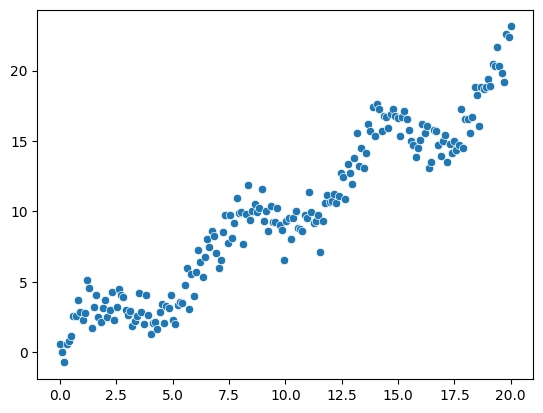

In [8]:
X = np.linspace(start=0, stop=20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)

sns.scatterplot(x=X, y=y)

In [47]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X.reshape(-1, 1)
        self.y = y.reshape(-1, 1)
    
    def __getitem__(self, index):
        inputs = torch.tensor(self.X[index], dtype=torch.float32)
        labels = torch.tensor(self.y[index], dtype=torch.float32)
        return inputs, labels
    
    def __len__(self):
        return self.X.shape[0]


def move_to(obj, device):
    if isinstance(obj, list):
        return [move_to(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(move_to(list(obj), device))
    elif isinstance(obj, set):
        return set(move_to(list(obj), device))
    elif isinstance(obj, dict):
        result = dict()
        for key, value in obj.items():
            result[move_to(key, device)] = move_to(value, device)
        return result
    elif hasattr(obj, 'to'):
        return obj.to(device)
    else:
        return obj
    

def train_simple_network(model, loss_function, training_loader, device, epochs, learning_rate):
    optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
    model.to(device)
    
    for epoch in tqdm(range(epochs), desc='Epoch'):
        model = model.train()
        running_loss = 0.0
        
        for inputs, labels in training_loader:
            inputs = move_to(inputs, device)
            labels = move_to(labels, device)
            
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            

def visualize_2d_softmax(X, y, model, device, title=None):
    x_min = np.min(X[:, 0]) - 0.5
    x_max = np.max(X[:, 0]) + 0.5
    y_min = np.min(X[:, 1]) - 0.5
    y_max = np.max(X[:, 1]) + 0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20), np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1, 1), yv.reshape(-1, 1)))
    
    with torch.no_grad():
        inputs = torch.tensor(data=xy_v, dtype=torch.float32).to(device)
        logits = model(inputs)
        y_pred = F.softmax(logits, dim=1)
        
    cs = plt.contourf(xv, yv, y_pred[:, 0].reshape(20, 20), levels=np.linspace(0, 1, num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [18]:
input_features = 1
output_features = 1
model = nn.Linear(input_features, output_features)

loss_function = nn.MSELoss()

regression_dataset = SimpleDataset(X, y)
training_loader = DataLoader(dataset=regression_dataset, shuffle=True)

train_simple_network(model, loss_function, training_loader, device, epochs=20, learning_rate=0.001)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 76.45it/s]


<Axes: >

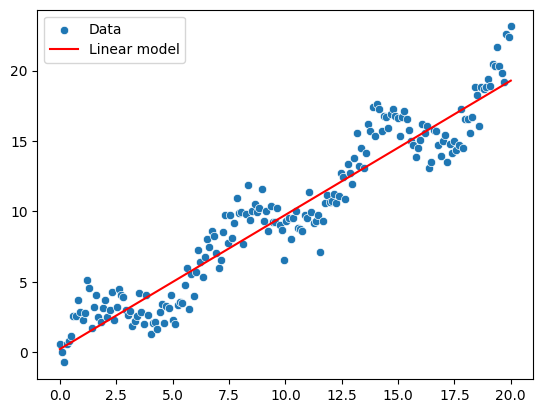

In [21]:
with torch.no_grad():
    inputs = torch.tensor(data=X.reshape(-1, 1), dtype=torch.float32).to(device)
    y_pred = model(inputs).cpu().numpy()
    
sns.scatterplot(x=X, y=y, label='Data')
sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear model')

In [31]:
hidden_features = 10
model = nn.Sequential(
    nn.Linear(input_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, output_features),
)
train_simple_network(model, loss_function, training_loader, device, epochs=200, learning_rate=0.001)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 63.30it/s]


<Axes: >

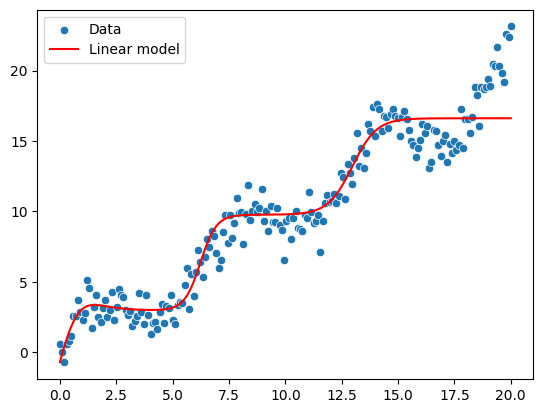

In [32]:
with torch.no_grad():
    inputs = torch.tensor(data=X.reshape(-1, 1), dtype=torch.float32).to(device)
    y_pred = model(inputs).cpu().numpy()
    
sns.scatterplot(x=X, y=y, label='Data')
sns.lineplot(x=X, y=y_pred.ravel(), color='red', label='Linear model')

<Axes: >

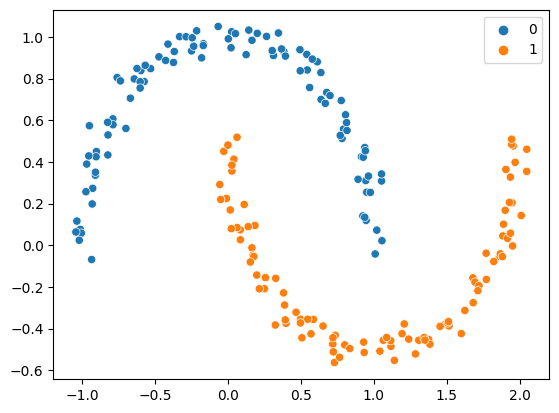

In [36]:
X, y = make_moons(n_samples=200, noise=0.05)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [41]:
classification_dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
classification_dataset[0]

(tensor([0.5399, 0.9158]), tensor(0))

In [45]:
training_loader = DataLoader(dataset=classification_dataset, shuffle=True)

input_features = 2
output_features = 2
model = nn.Linear(input_features, output_features)

loss_function = nn.CrossEntropyLoss()

train_simple_network(model, loss_function, training_loader, device, epochs=20, learning_rate=0.001)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 83.08it/s]


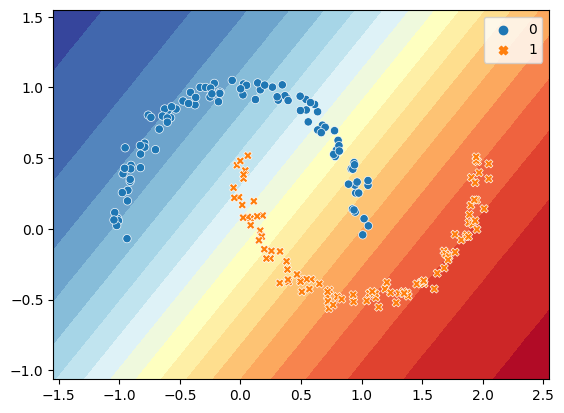

In [48]:
visualize_2d_softmax(X, y, model, device)

In [57]:
hidden_features = 30

model = nn.Sequential(
    nn.Linear(input_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, hidden_features),
    nn.Tanh(),
    nn.Linear(hidden_features, output_features),
)

train_simple_network(model, loss_function, training_loader, device, epochs=220, learning_rate=0.001)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:04<00:00, 53.81it/s]


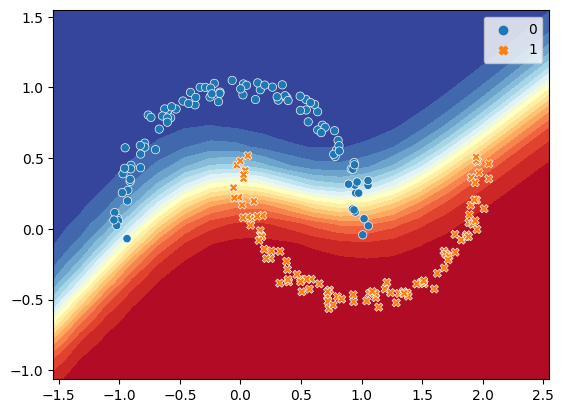

In [58]:
visualize_2d_softmax(X, y, model, device)